# Proyecto: Predicción de Abandono de Clientes Bancarios

## Introducción a los Datasets

### Dataset 1: Predicción de Abandono de Clientes Bancarios (Bank Customer Churn)

**Descripción General:**
Este conjunto de datos contiene información sobre clientes de un banco y su comportamiento, con el objetivo de predecir si un cliente abandonará o no el banco (*churn*). La variable objetivo es `Exited`, que indica si el cliente dejó de ser parte del banco (`1`) o si permaneció (`0`).

**Características del Dataset (Variables relevantes):**
- `CustomerId`: Identificador único del cliente.
- `Surname`: Apellido del cliente.
- `CreditScore`: Puntuación de crédito del cliente.
- `Geography`: País de residencia (ej. Francia, España, Alemania).
- `Gender`: Género del cliente.
- `Age`: Edad del cliente.
- `Tenure`: Años de permanencia en el banco.
- `Balance`: Saldo promedio del cliente.
- `NumOfProducts`: Número de productos que el cliente tiene con el banco.
- `HasCrCard`: Indica si tiene tarjeta de crédito.
- `IsActiveMember`: Indica si el cliente es considerado activo.
- `EstimatedSalary`: Salario estimado del cliente.
- `Exited`: (Variable objetivo) `1` si el cliente se fue del banco, `0` si sigue.

**Objetivo del Proyecto:**
Analizar los factores que influyen en la decisión de un cliente de abandonar el banco. A partir de esto, se puede crear un modelo predictivo que ayude al banco a identificar clientes en riesgo y tomar medidas preventivas de retención.



## 1. Información General
- **Nombre del Proyecto**: 
- **Nombres del Equipo y Roles**:
  - Integrante 1 - Rol
  - Integrante 2 - Rol
- **Resumen del Proyecto**:
Este proyecto busca identificar los factores que influyen en el abandono de clientes usando modelos de analítica de negocios y aprendizaje automático.

## 2. Perspectiva del Negocio
- Contexto del problema y por qué es relevante en el entorno empresarial.
- Impacto potencial de las predicciones.
- Aplicaciones reales en la toma de decisiones.

## 3. Análisis Exploratorio de Datos
- Cargar dataset.
- Revisar estructura de datos.
- Estadísticas descriptivas.
- Visualización inicial.

In [1]:
# Cargar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
from sklearn.metrics import classification_report,accuracy_score

In [3]:
# Cargar datos
df = pd.read_csv("Churn_Modelling.csv")

In [4]:
print("\nValores Faltantes:")
print(df.isnull().sum())


Valores Faltantes:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [5]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min 


Distribucion de Variable Target:
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


C:\Users\gabri\AppData\Local\Temp\ipykernel_13624\1630244663.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Exited', data=df, palette='coolwarm')


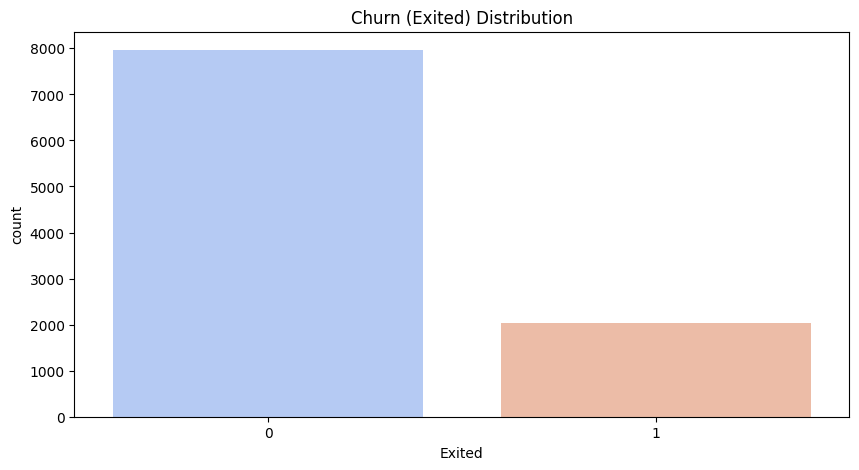

In [6]:
print("\nDistribucion de Variable Target:")
print(df['Exited'].value_counts(normalize=True))

plt.figure(figsize=(10,5))
sns.countplot(x='Exited', data=df, palette='coolwarm')
plt.title('Churn (Exited) Distribution')
plt.show()

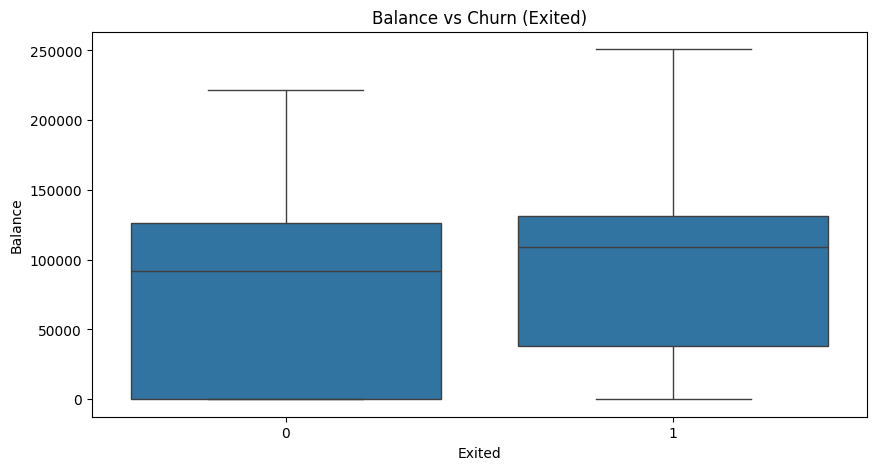

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Exited', y='Balance', data=df)
plt.title('Balance vs Churn (Exited)')
plt.show()

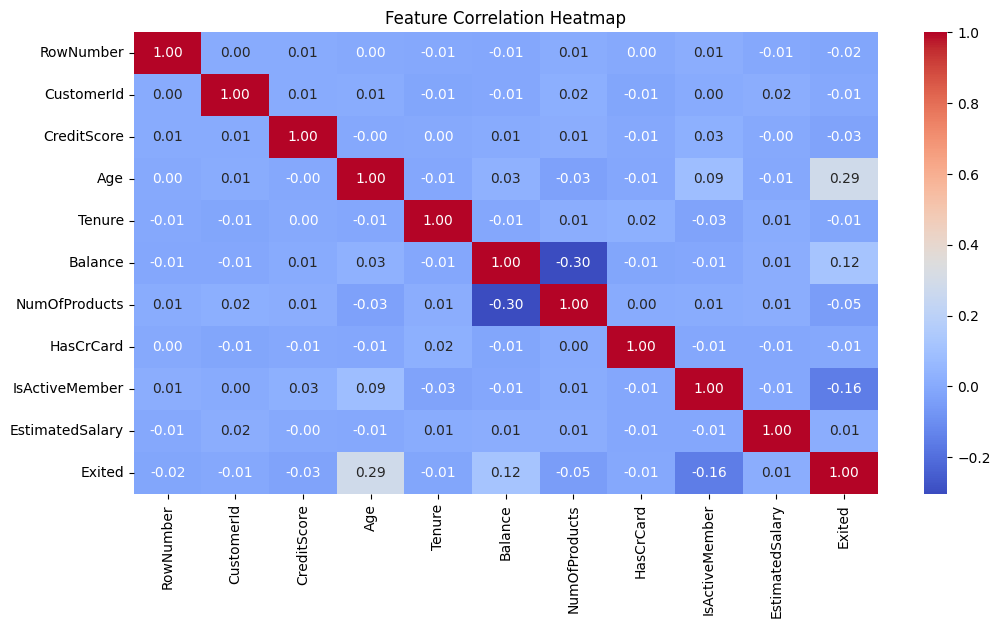

In [8]:
numeric_df = df.select_dtypes(include=['number'])  # Exclude non-numeric columns
plt.figure(figsize=(12,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

## 4. Preprocesamiento y Limpieza de Datos
- Identificación y manejo de valores nulos o duplicados.
- Transformaciones necesarias.
- Codificación y escalamiento si aplica.

In [ ]:
# Preprocesamiento del dataset
a

## 5. Modelado Predictivo
- División de datos de entrenamiento y prueba.
- Selección de modelos.
- Entrenamiento y validación.

In [ ]:
# Entrenamiento de modelos
a

## 6. Evaluación del Modelo
- Métricas de evaluación.
- Interpretación de resultados.
- Ajustes necesarios.

In [ ]:
# Evaluación del modelo
a

## 7. Visualización de Resultados
- Crear visualizaciones relevantes.
- Mostrar resultados clave.

In [ ]:
# Visualizaciones finales
a

## 8. Conclusiones y Recomendaciones
- Conclusiones generales basadas en el análisis.
- Recomendaciones prácticas para el negocio.

## 9. Documentación Técnica
- Explicación de cómo ejecutar el proyecto paso a paso.
- Herramientas utilizadas con breve descripción y enlaces.
- Repositorio con código/documentación si aplica.

## 10. Recursos Adicionales
- Enlaces útiles.
- Lecturas recomendadas.
- Otros materiales de apoyo.